# CESM-LE analysis template
 - analysis should be performed on Casper
 - works with historical and SSP
     - monthly data functionality for CESM1
     - 3hrly, daily, monthly for CESM2
 - currently configured for lnd output
     - make mods to file_dict() to support atm, etc.
         - change the 'lnd' str
         - make sure the correct tapes are reference for different output streams
 - daniel kennedy, djk2120@ucar.edu

In [24]:
import numpy as np
import xarray as xr
import glob
import matplotlib
import matplotlib.pyplot as plt
import cftime
import dask
import os
from scipy import stats
%matplotlib inline

In [25]:
## was working with 16.2
xr.__version__

'0.16.2'

In [26]:
## was working with 2020.12.0
dask.__version__

'2020.12.0'

### run this cell to check if you have LENS2 read access:

In [27]:
samplefile = ('/glade/campaign/cgd/cesm/CESM2-LE/timeseries/lnd/proc/tseries/month_1/NBP/'+
              'b.e21.BHISTcmip6.f09_g17.LE2-1001.001.clm2.h0.NBP.199001-199912.nc')
cmd = 'stat '+samplefile
if os.system(cmd)!=0:
    print('you may not have access')
else:
    print('looks good')

looks good


### Fetch cluster

In [6]:
#for use on Casper: ONLY RUN THIS CELL ONCE  
#   note you may need to change the project number
ncores = 36
nmem   = str(int(375*ncores/36))+'GB'
from dask_jobqueue import PBSCluster
from dask.distributed import Client
cluster = PBSCluster(
    cores=ncores, # The number of cores you want
    memory=nmem, # Amount of memory
    processes=ncores, # How many processes
    queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
    resource_spec='select=1:ncpus='+str(ncores)+':mem='+nmem, # Specify resources
    project='P93300641', # Input your project ID here
    walltime='3:00:00', # Amount of wall time
    interface='ib0', # Interface to use
)
cluster.scale(ncores)
client = Client(cluster)

/glade/work/djk2120/miniconda3/envs/lens-py/lib/python3.7/site-packages/distributed/node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 36885 instead
  http_address["port"], self.http_server.port


In [10]:
# the extra workers can get stuck in the queue
#   stay here (rerunning cell) until you see that the workers>0
client

Client Scheduler: tcp://10.12.1.3:46658 Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/djk2120/proxy/{port}/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


### Data I/O functions:
 - you should run each of these cells and then proceed to START HERE
 - you should not need to edit these function
 - (unless you want to add some missing functionality)

In [19]:
def get_members(model):
    members = []
    if model =='CESM1':
        members = [str(i).zfill(3) for i in [*(1+np.arange(35)),*(101+np.arange(7))]]
    else:
        for i,j in zip(1001+20*np.arange(10),1+np.arange(10)):
            s = 'LE2-'+str(i)+'.'+str(j).zfill(3)
            members.append(s)
        for i in [1231,1251,1281,1301]:
            for j in 1+np.arange(10):
                s = 'LE2-'+str(i)+'.'+str(j).zfill(3)
                members.append(s)
    return members

In [31]:
htapes = {}
htapes['lnd'] = {'month_1':'.h0.','day_1':'.h5.','hour_3':'.h7.'}
htapes['atm'] = {'day_1':'.h0.'}

In [44]:
## Updated for new directory structure of LENS2
def file_dict(model,mem,field,hist=True,freq='monthly',component='lnd'):
    ''' returns a dictionary of filepaths keyed by year, for a given ensemble member/field '''
    mm = get_members(model)[mem]
    filepaths = {}
    
    #detailing the directory structure
    if model=='CESM1':
        topdir = '/glade/collections/cdg/data/cesmLE/CESM-CAM5-BGC-LE/'+component+'/proc/tseries/'
        if hist: runtype = 'b.e11.B20TRC5CNBDRD.f09_g16.'
        else:    runtype = 'b.e11.BRCP85C5CNBDRD.f09_g16.'
    else:
        topdir  = '/glade/campaign/cgd/cesm/CESM2-LE/timeseries/'+component+'/proc/tseries/'
        if hist: runtype = 'b.e21.BHISTcmip6.f09_g17.'
        else:    runtype = 'b.e21.BSSP370cmip6.f09_g17.'
        
    #check htape dictionary
    if freq in htapes[component]:
        tape = htapes[component][freq]
    else:
        raise ValueError('ERROR: \''+freq+'\' freq not supported for '+model)
    thisdir = topdir+freq+'/'+field+'/'

    #find all the relevant files
    files = glob.glob(thisdir+runtype+'*'+tape+field+'*')
   
    #create a dictionary mapping yr-->filepath
    for file in files:
        #isolate y1 and y2 from the file name
        ystr = file.split(field)[-1]
        y1 = int(ystr[1:5])
        ystr = ystr.split('-')[1]
        y2 = int(ystr[0:4])
        for yy in np.arange(y1,y2+1):
            filepaths[yy]=file
       
    return filepaths

In [13]:
def get_file(model,mem,field,year,freq='monthly'):
    ''' get a single file for the given model-mem-field-year'''
    hist = True
    if model=='CESM1' and year>2005: hist=False
    if model=='CESM2' and year>2014: hist=False

    filepaths = file_dict(model,mem,field,hist,freq)
    if year in filepaths.keys():
        file = filepaths[year]
    else:
        print('file not found for that member')
        file = []
    
    return file

In [14]:
def all_files(model,ens,field,firstyear,lastyear,freq='monthly'):
    ''' retrieve a list of files containing the given ensemble'''
    ens = np.array(ens)
    yrs = np.arange(firstyear,lastyear+1)
    files = []    # a list of lists, dim0=ens, dim1=time
    ix = np.zeros(ens.shape)+1
    
    for ee,i in zip(ens,range(len(ens))):
        ffs = []  # a list of files for this ee
        file0 = ''
        first = True
        for yr in yrs:
            #fetch filepaths
            if first:
                hist = True
                if model=='CESM1' and yr>2005: hist=False
                if model=='CESM2' and yr>2014: hist=False
                filepaths = file_dict(model,ee,field,hist,freq)
                first     = False  
            #append file if it is new
            if yr in filepaths.keys():
                file = filepaths[yr]
                if file != file0:
                    ffs.append(file)
                    file0 = file

            #trigger new filepaths fetch when needed
            if model=='CESM1' and yr==2005: first=True
            if model=='CESM2' and yr==2014: first=True

        
        #append this ensemble member to files
        if ffs:  #only append if you found files
            files.append(ffs)
        else:
            ix[i] = 0
    return files,ens[ix==1]

In [23]:
def get_data(model,ens,fields,firstyear,lastyear,freq,chunks={'time':360}):
    ''' returns an xarray dataset containing the requested ensemble
    model = \'CESM1\' or \'CESM2\'
    ens   = list of members, via simple sequential key e.g. range(50) gets the first 50 members
            [0,2,4] would get the first, third, and fifth ensemble members (see get_members)
    fields = list of desired fields, you do not need to ask for lat/lon/time
    firstyear = int [1850-2100]
    lastyear  = int [1850-2100]
    freq = \'monthly\' or \'daily\' or \'3hr\' '''

    ds = xr.Dataset()    #instantiate Dataset

    #allow for single field or list of fields
    if type(fields)==str: fields=[fields]  
    
    #add fields one at a time to the dataset
    for field in fields:
        files,ens = all_files(model,ens,field,firstyear,lastyear,freq)
        ensdim  = xr.DataArray(ens, dims='ens', name='ens')
        dims    = [ensdim,'time']
        # check if all members have the same number of files (not guaranteed)
        nfs = np.array([len(ffs) for ffs in files])
        if np.sum(nfs==nfs[0])==len(nfs):
            one_go=True   # same number of files
        else:
            one_go=False
        if one_go: #read all data in one go
            tmp = xr.open_mfdataset(files,combine='nested',parallel=True,
                                    concat_dim=dims,chunks=chunks)
        else:      #read data one member at a time and then concat
            dsets = []
            for ffs in files:
                d0 = xr.open_mfdataset(ffs,combine='nested',parallel=True,
                                    concat_dim=['time'],chunks=chunks)
                dsets.append(d0)
            tmp = xr.concat(dsets,dim=ensdim)
        ds[field] = tmp[field]

    #grab one copy of the various extra variables, e.g. landfrac,area
    tmp = xr.open_dataset(files[0][0])
    for thisvar in tmp.data_vars:
        if 'time' not in tmp[thisvar].coords:
            ds[thisvar]=tmp[thisvar]

    # quick fix to adjust time vector for monthly data        
    if freq=='monthly':
        nmonths = len(ds.time)
        yr0 = ds['time.year'][0].values
        ds['time'] =xr.cftime_range(str(yr0),periods=nmonths,freq='MS')

    return ds.sel(time=slice(str(firstyear),str(lastyear)))

In [16]:
def get_landarea(model):
    file= get_file(model,0,'GPP',1990)
    ds = xr.open_dataset(file)
    la = ds['area']*ds['landfrac']
    return la

In [17]:
def month_wts(nyears):
    days_pm  = [31,28,31,30,31,30,31,31,30,31,30,31]
    return xr.DataArray(np.tile(days_pm,nyears),dims='time')

# Start editing here:
 - note: you don't have to %%time things
     - just wanted to give a sense of how long various steps take for me

### a lot of data if you take the full dataset, even for just a couple variables

In [60]:
%%time
model = 'CESM2'
ens = range(50)
fields = ['NBP','TWS']
firstyear = 1850
lastyear  = 2100
freq      = 'monthly'
ds = get_data(model,ens,fields,firstyear,lastyear,freq)
ds.nbytes/1e9 #GB

CPU times: user 45.4 s, sys: 2.24 s, total: 47.6 s
Wall time: 1min 2s


66.660018108

### can also get daily data, only working for CESM2 as of now
 - available fields listed at the bottom of notebook 
 - first 10 ensemble members don't have daily GPP, etc.

In [84]:
%%time
model = 'CESM2'
ens = 10+np.arange(40)
fields = ['NBP','TWS']
firstyear = 1990
lastyear  = 1999
freq      = 'daily'
ds = get_data(model,ens,fields,firstyear,lastyear,freq)
ds.nbytes/1e9 #GB

CPU times: user 2.28 s, sys: 144 ms, total: 2.43 s
Wall time: 3.62 s


64.587528912

### short example analysis

In [92]:
help(get_data)

Help on function get_data in module __main__:

get_data(model, ens, fields, firstyear, lastyear, freq)
    returns an xarray dataset containing the requested ensemble
    model = 'CESM1' or 'CESM2'
    ens   = list of members, via simple sequential key e.g. range(50) gets the first 50 members
            [0,2,4] would get the first, third, and fifth ensemble members (see get_members)
    fields = list of desired fields, you do not need to ask for lat/lon/time
    firstyear = int [1850-2100]
    lastyear  = int [1850-2100]
    freq = 'monthly' or 'daily'



### read in the data

In [100]:
%%time
model = 'CESM2'
ens = range(50)
fields = ['GPP','TWS']
firstyear = 1985
lastyear  = 2014
freq      = 'monthly'
ds = get_data(model,ens,fields,firstyear,lastyear,freq)

CPU times: user 9 s, sys: 908 ms, total: 9.91 s
Wall time: 11.9 s


### analysis...

In [123]:
#compute annual total GPP
nyears  = len(np.unique(ds['time.year']))
cf = 24*60*60           # used to convert /s to /d
dpm = month_wts(nyears) # days per month, function defined above
gpp_ann = cf*(dpm*ds.GPP).groupby('time.year').sum(skipna=True) # gridded annual total gpp

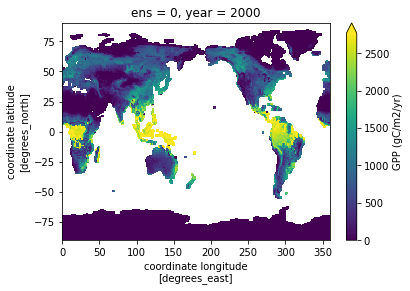

In [105]:
# plot one year from one ensemble member
#   where statement masks the ocean
#   cbar_kwargs ... colorbar keyword arguments
la = get_landarea('CESM2')
gpp_ann.sel(ens=0,year=2000).where(la>0).plot(cbar_kwargs={'label':'GPP (gC/m2/yr)'},robust=True);

In [120]:
# sum across gridcells, weighting by landarea
cf1 = 1e6    #km2-->m2
cf2 = 1e-15  #gC-->PgC
gpp_ann_glob = cf1*cf2*(la*gpp_ann).sum(skipna=True,dim=['lat','lon'])

In [118]:
%%time
##  force the calculation:
##     xarray uses lazy evaluation, avoiding crunching the numbers 
##     up to this point, I haven't actually done any calculations!
##     xarray waits until I explicitly require it to do so
##     best to do this separate from plotting for big calculations
##  Note that if you plan on reusing an intermediate result:
##     e.g. annual averages, 
##     you should probably force the calc and save it at that step
##  If you see files like core-casper25- appearing, you have an issue
gpp_ann_glob = gpp_ann_glob.compute()

CPU times: user 5.95 s, sys: 132 ms, total: 6.08 s
Wall time: 7.54 s


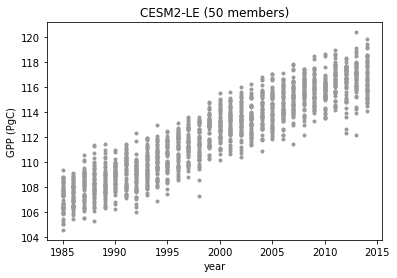

In [119]:
t = np.unique(ds['time.year'])
plt.plot(t,gpp_ann_glob,'.',color=[0.6,0.6,0.6])
plt.xlabel('year')
plt.ylabel('GPP (PgC)')
plt.title('CESM2-LE (50 members)');

### Extra functions

In [26]:
# colorbrewer colormap, diverging, brown->green
ccc = np.zeros([11,3]);
ccc[0,:] = 84,48,5
ccc[1,:] = 140,81,10
ccc[2,:] = 191,129,45
ccc[3,:] = 223,194,125
ccc[4,:] = 246,232,195
ccc[5,:] = 245,245,245
ccc[6,:] = 199,234,229
ccc[7,:] = 128,205,193
ccc[8,:] = 53,151,143
ccc[9,:] = 1,102,94
ccc[10,:] = 0,60,48
ccc = matplotlib.colors.ListedColormap(ccc/256)

In [25]:
def detrend_dim(da, dim, deg=1):
    # detrend along a single dimension (h/t rabernat)
    p = da.polyfit(dim=dim, deg=deg)
    fit = xr.polyval(da[dim], p.polyfit_coefficients)
    return da - fit

In [82]:
#list of daily variables
thedir = '/glade/campaign/cesm/collections/CESM2-LE/archive/b.e21.BHISTcmip6.f09_g17.LE2-1231.001/lnd/proc/tseries/day_1/'
files = os.popen('ls '+thedir+'*h5*1850*').read().split('\n')[:-1]
for file in files:
    str1 = file.split('.h5.')[1]
    str2 = str1.split('.')[0]
    print(str2)

ALT
AR
EFLX_GRND_LAKE
EFLX_LH_TOT
FAREA_BURNED
FGR12
FGR
FIRA
FIRE
FLDS
FSA
FSDS
FSDSND
FSDSNI
FSDSVD
FSDSVI
FSH
FSM
FSNO
GPP
H2OCAN
H2OSFC
H2OSNO
HR
JCONVECT
LAKEICETHICK
NBP
NEP
NFIRE
NPP
QDRAI
QDRAI_PERCH
QFLX_SNOW_DRAIN
QFLX_SUB_SNOW
QINTR
QOVER
QRGWL
QRUNOFF
QSNOEVAP
QSNOFRZ
QSOIL
QVEGE
QVEGT
RAIN
SABG
SNOBCMSL
SNOCAN
SNOFSRND
SNOFSRNI
SNOFSRVD
SNOFSRVI
SNOTXMASS
SNOW
SNOWDP
SNOWICE
SNOWLIQ
SOILICE
SOILLIQ
SOILWATER_10CM
TAUX
TAUY
TG
TKE1
TLAI
TLAKE
TOTSOILICE
TOTSOILLIQ
TSKIN
TSOI
TV
TWS
UST_LAKE
